## Lasso Regression Modelling

#### Using lasso regression, let's predict trust in government

Lasso regression provides the opportunity to compare models to determine if regression (treating response variables as continuous even though they are ordinal) would fit the data best. 

The following modeling allows for manipulation of class labels, categorical or binary responses, and feature selection. This is an experimental model and should not be counted as fully deterministic. 

In [1]:
import numpy as np
# set a seed for reproducibility
np.random.seed(23)

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# to scale our data
from sklearn.preprocessing import MinMaxScaler

# to generate k-folds from the data
from sklearn.model_selection import KFold, train_test_split

# use sklearn.metrics to calculate a confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# to calulate distance matrix
from sklearn.metrics import pairwise_distances

# to use in building graphs for DT
import graphviz 

# to use in viewing feature importance from random forest 
import seaborn as sns

# to export dataframes
import dataframe_image as dfi

# to build out Lasso regression 
from sklearn.linear_model import LassoCV

In [2]:
# import data

# import imputted testing data
testI = pd.read_csv(r'/Users/natalie_kraft/Documents/LAS/Pew2017_ITest.csv')
# import imputted training data
trainI = pd.read_csv(r'/Users/natalie_kraft/Documents/LAS/Pew2017_ITrain.csv')

# import imputted testing data
testT = pd.read_csv(r'/Users/natalie_kraft/Documents/LAS/Pew2017_TTest.csv')
# import imputted testing data
trainT = pd.read_csv(r'/Users/natalie_kraft/Documents/LAS/Pew2017_TTest.csv')


In [3]:
testI = testI.drop(columns=['Unnamed: 0'])
trainI = trainI.drop(columns=['Unnamed: 0'])
testT = testT.drop(columns=['Unnamed: 0'])
trainT = trainT.drop(columns=['Unnamed: 0'])

## The following functions are defined as... 

> discretize (mapping, labelName, df): turns the categorical/ordinal response into binary or other discretized value   

> dtree(x_train, y_train, x_test, criterion, random_state, depth, prob): creates a decision tree using the training data set and then predicts the labels for the test dataset
- users can specify tree depth as well as use of gini/entropy 
- return the tree and the prediction accuracy

> randomforest(x_train, y_train, x_test, criterion, random_state, depth, prob): builds 100 decision trees to determine relevance of attributes based on different split
- returns all of the trees and the prediction accuracies 

> featureImportance(x_train, y_train, x_test, criterion, random_state, depth, prob, runningModel, threshold): builds a random forest, calculates feature importance based off the forest, determines relevant attributes to model, builds reduced attribute model
- returns model with reduced attributes based upon threshold set

> evaluation_measures(y_true, y_pred): determining accuracy and confusion matrix

In [4]:
def evaluation_measures(y_true, y_pred):

    # binary equivalent for accuracy
    # cm = confusion_matrix(true_labels, pred_labels)
    # accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
    
    cm = confusion_matrix(y_true, y_pred)
    # tp + tn / tp + tn + fp + fn
    # generic values used in anticipation of test cases having more than two class labels
    accuracy = sum(cm[i][i] for i in range(cm.shape[0])) / cm.sum()
    
    # return as a list
    return [accuracy, cm]

In [5]:
def feature_importance(reg, accuracy, modelColumns):
    
    features = []
    removedFeatures = []
    # Which attributes are most predictive of the outcome variable?
    for i in range(0, len(reg.coef_)):
        if reg.coef_[i] != 0:
            features.append([modelColumns[i], reg.coef_[i]])
        else:
            removedFeatures.append(modelColumns[i])
            
   
    print(f'Model coefficients:\n{features}')
    
    print()
    print(f'Model features removed include:\n {removedFeatures}')

    print()
    # Note we called this 'lamda' in class, but sklearn calls it alpha (should be ~3.196)
    print(f'The shinkage coefficient hyperparameter chosen by CV: {reg.alpha_}')
    
    return features

In [6]:
def regression_lasso(X_train, X_test, y_train, y_test, i, random_state, printC, modelColumns):
    
    reg = LassoCV(cv=i, random_state=random_state).fit(X_train, y_train)
    pred = reg.predict(X_test)
    
    pred = np.around(pred)
    accuracy, cm = evaluation_measures(y_test, pred)
    
    if printC is True:
        features = feature_importance(reg, accuracy, modelColumns)
    else:
        features = []
        
    error = calculate_rmse(y_test, pred)
    print("The error is : " + str(error))
        
    return [accuracy, cm, pred, error, features]

In [7]:
def regression_lasso_cross(label, X_train, X_test, y_train, y_test, random_state):
    
    scatter = []
    highestVal = 0
    bestCross = -1
    
    for i in range(2, 20):
        
        evaluations = regression_lasso(X_train, X_test, y_train, y_test, i, random_state, False, None)
        
        scatter.append([label, i, evaluations[0]])
        if evaluations[0] > highestVal: 
            highestVal = evaluations[0]
            bestCross = i
        
    return scatter, highestVal, bestCross, evaluations[4]

In [8]:
import math
def calculate_rmse(y_true, y_pred):
    # Inputs:
    # y_true: ground truth dependent variable values, of type vector
    # y_pred: prediction outcomes from any regression method, with the same length as y_true
  
    # Outputs:
    # a single value of type double, with the RMSE value
    return (math.sqrt(np.sum((y_true - y_pred)**2)/len(y_true)))

## Predict your model

#### What do you want to predict? Choose your variable first:
- RESPONSE : binary classification of either trust government (1) or not (0)
- trust_gov : ordinal classification of trust government (4) to don't trust government (1)

In [9]:
# choose your variable here 
# either RESPONSE or trust_gov
predictor = "RESPONSE"

# allVars = ['RESPONSE', 'trust_gov']
allVars = ['trust_gov', 'RESPONSE']

### Run model with each response variable 

Determine accuracy for each response variable based off a determination on model's best cross validation splits

__Average results for full and reduced responses__
In order to show the benefits of reducing the categorical/ordinal responses of response variables into larger 
groups, the average for all predictors is laid out. 

In [10]:
modelStatus = []
graphs = []

dataset = trainI.drop(columns=['Country', 'ID']).copy()
datasetTest = testI.drop(columns=['Country', 'ID']).copy()

for idx in range(0, len(allVars)): 
    
    print("\nLet's work on " + allVars[idx] + "\n")
    
    ytrain = dataset[allVars[idx]]
    xtrain = dataset.drop(columns=['trust_gov', 'RESPONSE'])
    
    ytest = datasetTest[allVars[idx]]
    xtest = datasetTest.drop(columns=['trust_gov', 'RESPONSE'])
    
    scatter, highestVal, bestCross, features = regression_lasso_cross(allVars[idx], xtrain, xtest, ytrain, ytest, 33)
    
    graphs.append(scatter)
    modelStatus.append([allVars[idx], highestVal, bestCross])
    
    print("Accuracy for " + allVars[idx] + " is: " + str(highestVal))
    print("Valuable features for " + allVars[idx] + " include: \n")
    f = regression_lasso(xtrain, xtest, ytrain, ytest, bestCross, 33, True, xtrain.columns )

modelStatus


Let's work on trust_gov

The error is : 0.8671806549557707
The error is : 0.8588947716879827
The error is : 0.8559479157504258
The error is : 0.8548332546241337
The error is : 0.8565047023283658
The error is : 0.8559479157504258
The error is : 0.8546101479376707
The error is : 0.8575616008856164
The error is : 0.8546101479376707
The error is : 0.8509204420975898
The error is : 0.8560036107054739
The error is : 0.8548332546241337
The error is : 0.8546101479376707
The error is : 0.8548332546241337
The error is : 0.8519283103167459
The error is : 0.8548332546241337
The error is : 0.8565047023283658
The error is : 0.8560036107054739
Accuracy for trust_gov is: 0.4622425629290618
Valuable features for trust_gov include: 

Model coefficients:
[['desc_day', 0.006629904599063995], ['nostalgia50', 0.13187598620186808], ['econ_sit', 0.3396803206093876], ['children_betteroff2', 0.08323105104298141], ['fav_Iran', -0.063355215046037], ['fav_Germany', 0.00352302191945769], ['fav_India', 0.0029116570

The error is : 0.4954022012073608
The error is : 0.4930872249832149
The error is : 0.493666986764874
The error is : 0.4893020293975287
The error is : 0.4949208074475614
The error is : 0.49173178924623256
The error is : 0.4946317463069013
The error is : 0.4933771910329651
The error is : 0.49240997349614524
The error is : 0.4873494995445579
The error is : 0.49240997349614524
The error is : 0.49173178924623256
The error is : 0.49202255410218
The error is : 0.4949208074475614
The error is : 0.48822910429031685
The error is : 0.4933771910329651
The error is : 0.4937635475456048
The error is : 0.49202255410218
Accuracy for RESPONSE is: 0.7624904652936689
Valuable features for RESPONSE include: 

Model coefficients:
[['desc_day', 0.0017602568645275138], ['nostalgia50', 0.05864655091316339], ['econ_sit', 0.1391499390647608], ['improve_econ', 0.02079668449989956], ['children_betteroff2', 0.03725154582911686], ['satisfied_democracy', 0.020974380325129074], ['fav_Iran', -0.022800081648498487], ['

[['trust_gov', 0.4622425629290618, 11], ['RESPONSE', 0.7624904652936689, 11]]

In [11]:
graphs

[[['trust_gov', 2, 0.4376430205949657],
  ['trust_gov', 3, 0.4506102212051869],
  ['trust_gov', 4, 0.4545194508009153],
  ['trust_gov', 5, 0.4583333333333333],
  ['trust_gov', 6, 0.45585430968726165],
  ['trust_gov', 7, 0.4545194508009153],
  ['trust_gov', 8, 0.4595728451563692],
  ['trust_gov', 9, 0.4520404271548436],
  ['trust_gov', 10, 0.4595728451563692],
  ['trust_gov', 11, 0.4622425629290618],
  ['trust_gov', 12, 0.4567124332570557],
  ['trust_gov', 13, 0.4583333333333333],
  ['trust_gov', 14, 0.4595728451563692],
  ['trust_gov', 15, 0.4583333333333333],
  ['trust_gov', 16, 0.46167048054919907],
  ['trust_gov', 17, 0.4583333333333333],
  ['trust_gov', 18, 0.45585430968726165],
  ['trust_gov', 19, 0.4567124332570557]],
 [['RESPONSE', 2, 0.7545766590389016],
  ['RESPONSE', 3, 0.7568649885583524],
  ['RESPONSE', 4, 0.7562929061784897],
  ['RESPONSE', 5, 0.76058352402746],
  ['RESPONSE', 6, 0.7550533943554538],
  ['RESPONSE', 7, 0.7581998474446987],
  ['RESPONSE', 8, 0.75533943554538

Text(0.5, 0, '# CV')

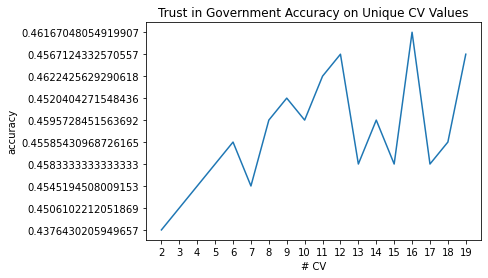

In [12]:
x = np.array(graphs[0])[:,1]
y = np.array(graphs[0])[:,2]
plt.plot(x, y)
plt.title("Trust in Government Accuracy on Unique CV Values")
plt.ylabel('accuracy')
plt.xlabel('# CV')

Text(0.5, 0, '# CV')

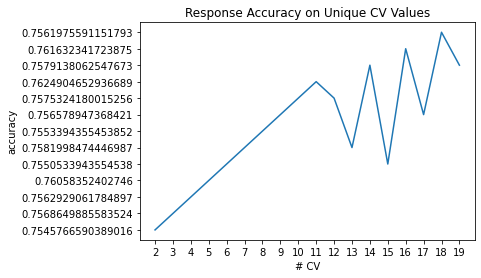

In [13]:
x = np.array(graphs[1])[:,1]
y = np.array(graphs[1])[:,2]
plt.plot(x, y)
plt.title("Response Accuracy on Unique CV Values")
plt.ylabel('accuracy')
plt.xlabel('# CV')

[[0.43764302 0.45061022 0.45451945 0.45833333 0.45585431 0.45451945
  0.45957285 0.45204043 0.45957285 0.46224256 0.45671243 0.45833333
  0.45957285 0.45833333 0.46167048 0.45833333 0.45585431 0.45671243]
 [0.75457666 0.75686499 0.75629291 0.76058352 0.75505339 0.75819985
  0.75533944 0.75657895 0.75753242 0.76249047 0.75753242 0.75819985
  0.75791381 0.75505339 0.76163234 0.75657895 0.75619756 0.75791381]]


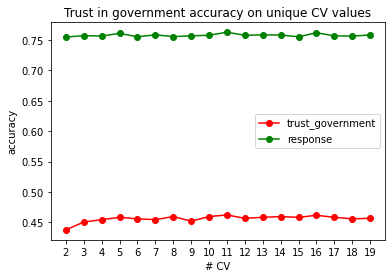

In [42]:
import pylab as plt

x = np.array(graphs)[:,:,1]
y = np.array(graphs)[:,:,2].astype(float)
print(y)
labels=['trust_government', 'response']
colors=['r','g']

plt.figure()

# loop over data, labels and colors
for i in range(len(y)):
    plt.plot(x[i],y[i],'o-',color=colors[i],label=labels[i])

plt.xlabel('# CV')
plt.ylabel('accuracy')
plt.title('Trust in government accuracy on unique CV values')
plt.legend()
#plt.yticks(np.arange(.4, .8, step=.05))
plt.show()

In [37]:
valuableFeatures = f[4]

In [16]:
df = pd.DataFrame(valuableFeatures, columns=['attributes', 'values'])

In [17]:
df.to_csv("/Users/natalie_kraft/Desktop/Lasso-TG.csv")

## Drop Invaluable Features 
### To ensure that only relevant features are utilized across all models
### Rerun model to determine accuracy

## Trust in Government 

1-4 ordinal responses 

In [18]:
trustGovGraph = []
variable = 'trust_gov'

In [19]:
testIQ = testI[['econ_sit', 'age', variable]]
trainIQ = trainI[['econ_sit', 'age', variable]]

ytrain = trainIQ[variable]
xtrain = trainIQ.drop(columns=[variable])
    
ytest = testIQ[variable]
xtest = testIQ.drop(columns=[variable])

scatter, highestVal, bestCross, features = regression_lasso_cross(variable, xtrain, xtest, ytrain, ytest, 33)
trustGovGraph.append([2, highestVal])

The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853
The error is : 0.9991415079258853


In [20]:
testIQ = testI[['econ_sit', 'age', 'nostalgia50', 'medwell_accuracy', 'medwell_unbiased', 'Trump_futureapproval', 'd_hhpeople', 
                'medwell_leaders', 'children_betteroff2', 'pray_several', variable]]
trainIQ = trainI[['econ_sit', 'age', 'nostalgia50', 'medwell_accuracy', 'medwell_unbiased', 'Trump_futureapproval', 'd_hhpeople', 
                  'medwell_leaders', 'children_betteroff2', 'pray_several', variable]]

ytrain = trainIQ[variable]
xtrain = trainIQ.drop(columns=[variable])
    
ytest = testIQ[variable]
xtest = testIQ.drop(columns=[variable])

scatter, highestVal, bestCross, features = regression_lasso_cross(variable, xtrain, xtest, ytrain, ytest, 33)
trustGovGraph.append([10, highestVal])

The error is : 0.9654599375028254
The error is : 0.9643235496796805
The error is : 0.9648672064917712
The error is : 0.9648672064917712
The error is : 0.964966020277323
The error is : 0.9655093153285835
The error is : 0.9655093153285835
The error is : 0.9653611742743431
The error is : 0.965262400940655
The error is : 0.9656080634050707
The error is : 0.9656080634050707
The error is : 0.9653611742743431
The error is : 0.9653611742743431
The error is : 0.9653611742743431
The error is : 0.9655093153285835
The error is : 0.9654105571515411
The error is : 0.9654105571515411
The error is : 0.9655093153285835


In [21]:
testIQ = testI[['econ_sit', 'age', 'nostalgia50', 'medwell_accuracy', 'medwell_unbiased', 'Trump_futureapproval', 
                'd_hhpeople', 'medwell_leaders', 'children_betteroff2', 'pray_several', 'political_scale2', 'confid_merkel', 
                'onlinenews', 'medwell_coverage', 'confid_xi', 'd_relig_commune_divine', 
                'fav_maduro', 'confid_castro', 'confid_trump', 'mfollow_othercountries', variable]]
trainIQ = trainI[['econ_sit', 'age', 'nostalgia50', 'medwell_accuracy', 'medwell_unbiased', 'Trump_futureapproval', 'd_hhpeople',
                  'medwell_leaders', 'children_betteroff2', 'pray_several', 'political_scale2', 'confid_merkel', 'onlinenews', 
                  'medwell_coverage', 'confid_xi', 'd_relig_commune_divine', 
                  'fav_maduro', 'confid_castro', 'confid_trump', 'mfollow_othercountries', variable]]

ytrain = trainIQ[variable]
xtrain = trainIQ.drop(columns=[variable])
    
ytest = testIQ[variable]
xtest = testIQ.drop(columns=[variable])

scatter, highestVal, bestCross, features = regression_lasso_cross(variable, xtrain, xtest, ytrain, ytest, 33)
trustGovGraph.append([20, highestVal])

The error is : 0.9375524394182113
The error is : 0.9340883129308108
The error is : 0.9340883129308108
The error is : 0.9338330905667116
The error is : 0.9338330905667116
The error is : 0.9335777984296884
The error is : 0.9335267316244957
The error is : 0.9334756620256378
The error is : 0.9330670046077716
The error is : 0.9327603940497563
The error is : 0.9332202721103151
The error is : 0.9327603940497563
The error is : 0.9330670046077716
The error is : 0.9327603940497563
The error is : 0.9330670046077716
The error is : 0.9334756620256378
The error is : 0.9340883129308108
The error is : 0.9330670046077716


In [22]:
testIQ = testI[['econ_sit', 'age', 'nostalgia50', 'medwell_accuracy', 'medwell_unbiased', 'Trump_futureapproval', 'd_hhpeople',
                  'medwell_leaders', 'children_betteroff2', 'pray_several', 'political_scale2', 'confid_merkel', 'onlinenews', 
                  'medwell_coverage', 'confid_xi', 'd_relig_commune_divine', 'fav_maduro', 'confid_castro', 'confid_trump', 
                  'mfollow_othercountries', 'fav_Cuba', 'polsys_republic', 'd_density', 'Trump_relations', 'Obama_pastapproval',
                  'intthreat_econcondition', 'fav_Germany', 'influ_humanrights', 'concern_country', 'd_adult_us', 'NKorea_nukes', 
                  'confid_putin', 'religion_import', 'fav_BJP', 'intthreat_refugee',
                  'relig_rituals_import', 'influ_mil', 'global_money', 'fav_Britain', 'humanrights_priority_police', variable]]
trainIQ = trainI[['econ_sit', 'age', 'nostalgia50', 'medwell_accuracy', 'medwell_unbiased', 'Trump_futureapproval', 'd_hhpeople',
                  'medwell_leaders', 'children_betteroff2', 'pray_several', 'political_scale2', 'confid_merkel', 'onlinenews', 
                  'medwell_coverage', 'confid_xi', 'd_relig_commune_divine', 'fav_maduro', 'confid_castro', 'confid_trump', 
                  'mfollow_othercountries', 'fav_Cuba', 'polsys_republic', 'd_density', 'Trump_relations', 'Obama_pastapproval',
                  'intthreat_econcondition', 'fav_Germany', 'influ_humanrights', 'concern_country', 'd_adult_us', 'NKorea_nukes', 
                  'confid_putin', 'religion_import', 'fav_BJP', 'intthreat_refugee',
                  'relig_rituals_import', 'influ_mil', 'global_money', 'fav_Britain', 'humanrights_priority_police', variable]]

ytrain = trainIQ[variable]
xtrain = trainIQ.drop(columns=[variable])
    
ytest = testIQ[variable]
xtest = testIQ.drop(columns=[variable])

scatter, highestVal, bestCross, features = regression_lasso_cross(variable, xtrain, xtest, ytrain, ytest, 33)
trustGovGraph.append([40, highestVal])

The error is : 0.9241339978984113
The error is : 0.9029466974122328
The error is : 0.9013084818224193
The error is : 0.92051580738191
The error is : 0.9007264633109319
The error is : 0.9153742362401484
The error is : 0.9005147269508575
The error is : 0.9016257881099548
The error is : 0.9032634282132322
The error is : 0.89982623968872
The error is : 0.9029466974122328
The error is : 0.9304575943367255
The error is : 0.9013613739607133
The error is : 0.9304575943367255
The error is : 0.89982623968872
The error is : 0.9021543839155256
The error is : 0.9004088400991833
The error is : 0.8999851681123824


In [23]:
testIQ = testI[['econ_sit', 'age', 'nostalgia50', 'medwell_accuracy', 'medwell_unbiased', 'Trump_futureapproval', 
                  'd_hhpeople', 'medwell_leaders', 'children_betteroff2', 'pray_several', 'political_scale2', 'confid_merkel', 
                  'onlinenews', 'medwell_coverage', 'confid_xi', 'd_relig_commune_divine', 'fav_maduro', 'confid_castro', 
                  'confid_trump', 'mfollow_othercountries', 'fav_Cuba', 'polsys_republic', 'd_density', 'Trump_relations', 
                  'Obama_pastapproval', 'intthreat_econcondition', 'fav_Germany', 'influ_humanrights', 'concern_country', 
                  'd_adult_us', 'NKorea_nukes', 'confid_putin', 'religion_import', 'fav_BJP', 'intthreat_refugee', 
                  'relig_rituals_import', 'influ_mil', 'global_money', 'fav_Britain', 'humanrights_priority_police', 
                  'intthreat_isis', 'mfollow_country', 'Kashmir_military', 'fav_EU', 'influence_humanrightsorgs', 
                  'American_democracy', 'mfollow_US', 'polsys_directdemocracy', 'improve_econ', 'influ_news', 
                  'humanrights_priority_religion', 'fav_SKorea', 'fav_Americans', 'intthreat_climatechange', 'fav_Japan', 
                  'humanrights_priority_enviro', 'fav_Saudi', 'humanrights_priority_justice', 'mfollow_city', 'polsys_junta',
                  'humanrights_priority_speech', 'Trump_personality_dangerous', 'legalabortion', 'modi_china', 
                  'Trump_personality_arrogant', 'd_relig_belief_Afterlife', 'd_relig_practice_offerings', 'd_relig_practice_gods',
                  'd_relig_belief_Reincarn', 'd_relig_belief_Angels', 'modi_communal_rel', 'Trump_policy_thewall',
                  'intthreat_USpower', 'd_relig_belief_gods',
                  'd_relig_belief_Demons', 'desc_day', 'Trump_policy_trade', 'd_numcell', 'modi_kashmir', 'fav_India', variable]]
trainIQ = trainI[['econ_sit', 'age', 'nostalgia50', 'medwell_accuracy', 'medwell_unbiased', 'Trump_futureapproval', 
                  'd_hhpeople', 'medwell_leaders', 'children_betteroff2', 'pray_several', 'political_scale2', 'confid_merkel', 
                  'onlinenews', 'medwell_coverage', 'confid_xi', 'd_relig_commune_divine', 'fav_maduro', 'confid_castro', 
                  'confid_trump', 'mfollow_othercountries', 'fav_Cuba', 'polsys_republic', 'd_density', 'Trump_relations', 
                  'Obama_pastapproval', 'intthreat_econcondition', 'fav_Germany', 'influ_humanrights', 'concern_country', 
                  'd_adult_us', 'NKorea_nukes', 'confid_putin', 'religion_import', 'fav_BJP', 'intthreat_refugee', 
                  'relig_rituals_import', 'influ_mil', 'global_money', 'fav_Britain', 'humanrights_priority_police', 
                  'intthreat_isis', 'mfollow_country', 'Kashmir_military', 'fav_EU', 'influence_humanrightsorgs', 
                  'American_democracy', 'mfollow_US', 'polsys_directdemocracy', 'improve_econ', 'influ_news', 
                  'humanrights_priority_religion', 'fav_SKorea', 'fav_Americans', 'intthreat_climatechange', 'fav_Japan', 
                  'humanrights_priority_enviro', 'fav_Saudi', 'humanrights_priority_justice', 'mfollow_city', 'polsys_junta',
                  'humanrights_priority_speech', 'Trump_personality_dangerous', 'legalabortion', 'modi_china', 
                  'Trump_personality_arrogant', 'd_relig_belief_Afterlife', 'd_relig_practice_offerings', 'd_relig_practice_gods',
                  'd_relig_belief_Reincarn', 'd_relig_belief_Angels', 'modi_communal_rel', 'Trump_policy_thewall',
                  'intthreat_USpower', 'd_relig_belief_gods',
                  'd_relig_belief_Demons', 'desc_day', 'Trump_policy_trade', 'd_numcell', 'modi_kashmir', 'fav_India', variable]]

ytrain = trainIQ[variable]
xtrain = trainIQ.drop(columns=[variable])
    
ytest = testIQ[variable]
xtest = testIQ.drop(columns=[variable])

scatter, highestVal, bestCross, features = regression_lasso_cross(variable, xtrain, xtest, ytrain, ytest, 33)
trustGovGraph.append([80, highestVal])

The error is : 0.9107795840931632
The error is : 0.8786496296162162
The error is : 0.8736982252834574
The error is : 0.8757692488716763
The error is : 0.8766397950596513
The error is : 0.8760413874845254
The error is : 0.8757692488716763
The error is : 0.8745708329669074
The error is : 0.8760413874845254
The error is : 0.8763134415848958
The error is : 0.8763678422703991
The error is : 0.8763678422703991
The error is : 0.8735890880367281
The error is : 0.8763678422703991
The error is : 0.8763134415848958
The error is : 0.8737527887948475
The error is : 0.8741891742828077
The error is : 0.8751157709180738


## RESPONSE

binary responses 

In [24]:
ResponseGraph = []
variable = 'RESPONSE'

In [25]:
testIQ = testI[['econ_sit', 'age', variable]]
trainIQ = trainI[['econ_sit', 'age', variable]]

ytrain = trainIQ[variable]
xtrain = trainIQ.drop(columns=[variable])
    
ytest = testIQ[variable]
xtest = testIQ.drop(columns=[variable])

scatter, highestVal, bestCross, features = regression_lasso_cross(variable, xtrain, xtest, ytrain, ytest, 33)
ResponseGraph.append([2, highestVal])

The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388
The error is : 0.5390013932328388


In [26]:
testIQ = testI[['econ_sit', 'age', 'political_scale2', 'medwell_unbiased', 'confid_castro', 'medwell_accuracy', 'd_hhpeople',
                'fav_Cuba', 'nostalgia50', 'intthreat_econcondition', variable]]
trainIQ = trainI[['econ_sit', 'age', 'political_scale2', 'medwell_unbiased', 'confid_castro', 'medwell_accuracy', 'd_hhpeople',
                'fav_Cuba', 'nostalgia50', 'intthreat_econcondition', variable]]

ytrain = trainIQ[variable]
xtrain = trainIQ.drop(columns=[variable])
    
ytest = testIQ[variable]
xtest = testIQ.drop(columns=[variable])

scatter, highestVal, bestCross, features = regression_lasso_cross(variable, xtrain, xtest, ytrain, ytest, 33)
ResponseGraph.append([10, highestVal])

The error is : 0.5255667820652041
The error is : 0.5256574830378469
The error is : 0.5251130422050299
The error is : 0.5252945851809653
The error is : 0.5246589099379417
The error is : 0.5256574830378469
The error is : 0.5256574830378469
The error is : 0.5257481683629479
The error is : 0.5256574830378469
The error is : 0.5256574830378469
The error is : 0.5251130422050299
The error is : 0.5256574830378469
The error is : 0.5256574830378469
The error is : 0.5255667820652041
The error is : 0.5256574830378469
The error is : 0.5256574830378469
The error is : 0.5257481683629479
The error is : 0.5256574830378469


In [27]:
testIQ = testI[['econ_sit', 'age', 'political_scale2', 'medwell_unbiased', 'confid_castro', 
                'medwell_accuracy', 'd_hhpeople', 'fav_Cuba', 'nostalgia50', 'intthreat_econcondition',
                'influ_gov', 'fav_NKorea', 'medwell_leaders', 'Trump_futureapproval', 'fav_SKorea', 'onlinenews',
                'fav_Saudi', 'pray_several', 'd_adult_us', 'fav_EU', variable]]
trainIQ = trainI[['econ_sit', 'age', 'political_scale2', 'medwell_unbiased', 'confid_castro', 
                'medwell_accuracy', 'd_hhpeople', 'fav_Cuba', 'nostalgia50', 'intthreat_econcondition',
                'influ_gov', 'fav_NKorea', 'medwell_leaders', 'Trump_futureapproval', 'fav_SKorea', 'onlinenews',
                'fav_Saudi', 'pray_several', 'd_adult_us', 'fav_EU', variable]]

ytrain = trainIQ[variable]
xtrain = trainIQ.drop(columns=[variable])
    
ytest = testIQ[variable]
xtest = testIQ.drop(columns=[variable])

scatter, highestVal, bestCross, features = regression_lasso_cross(variable, xtrain, xtest, ytrain, ytest, 33)
ResponseGraph.append([20, highestVal])

The error is : 0.5168776174259058
The error is : 0.515954456093536
The error is : 0.5161392204525804
The error is : 0.5158620490978825
The error is : 0.5153072591373067
The error is : 0.5149370670930202
The error is : 0.5157696255462856
The error is : 0.5153997656023078
The error is : 0.5153072591373067
The error is : 0.5152147360628313
The error is : 0.5153072591373067
The error is : 0.5153072591373067
The error is : 0.5152147360628313
The error is : 0.5149370670930202
The error is : 0.5156771854298435
The error is : 0.5153997656023078
The error is : 0.5153997656023078
The error is : 0.51502964004965


In [28]:
testIQ = testI[['econ_sit', 'age', 'political_scale2', 'medwell_unbiased', 'confid_castro', 'medwell_accuracy', 
                  'd_hhpeople', 'fav_Cuba', 'nostalgia50', 'intthreat_econcondition', 'influ_gov', 'fav_NKorea', 'medwell_leaders',
                  'Trump_futureapproval', 'fav_SKorea', 'onlinenews', 'fav_Saudi', 'pray_several', 'd_adult_us', 'fav_EU',
                  'polsys_republic', 'confid_merkel', 'fav_maduro', 'confid_trump', 'fav_Turkey', 'intthreat_USpower', 'fav_Iran',
                  'use_internet', 'Trump_relations', 'confid_xi', 'd_density', 'children_betteroff2', 'intthreat_ruspower',
                  'improve_econ', 'concern_country', 'd_homephone_us',
                  'intthreat_isis', 'mfollow_city', 'polsys_technocracy', 'mfollow_othercountries', variable]]
trainIQ = trainI[['econ_sit', 'age', 'political_scale2', 'medwell_unbiased', 'confid_castro', 'medwell_accuracy', 
                  'd_hhpeople', 'fav_Cuba', 'nostalgia50', 'intthreat_econcondition', 'influ_gov', 'fav_NKorea', 'medwell_leaders',
                  'Trump_futureapproval', 'fav_SKorea', 'onlinenews', 'fav_Saudi', 'pray_several', 'd_adult_us', 'fav_EU',
                  'polsys_republic', 'confid_merkel', 'fav_maduro', 'confid_trump', 'fav_Turkey', 'intthreat_USpower', 'fav_Iran',
                  'use_internet', 'Trump_relations', 'confid_xi', 'd_density', 'children_betteroff2', 'intthreat_ruspower',
                  'improve_econ', 'concern_country', 'd_homephone_us',
                  'intthreat_isis', 'mfollow_city', 'polsys_technocracy', 'mfollow_othercountries', variable]]
ytrain = trainIQ[variable]
xtrain = trainIQ.drop(columns=[variable])
    
ytest = testIQ[variable]
xtest = testIQ.drop(columns=[variable])

scatter, highestVal, bestCross, features = regression_lasso_cross(variable, xtrain, xtest, ytrain, ytest, 33)
ResponseGraph.append([40, highestVal])

The error is : 0.5034207924581345
The error is : 0.4996184661787014
The error is : 0.5016182812420991
The error is : 0.4996184661787014
The error is : 0.501808324166607
The error is : 0.4975148001355621
The error is : 0.4992366407762119
The error is : 0.4994275899668913
The error is : 0.4979936863761232
The error is : 0.49597925696641904
The error is : 0.4992366407762119
The error is : 0.49741896756217274
The error is : 0.49626753322264844
The error is : 0.49904561852289164
The error is : 0.4954022012073608
The error is : 0.4963635881027162
The error is : 0.4954022012073608
The error is : 0.49501712365114864


In [29]:
testIQ = testI[['econ_sit', 'age', 'political_scale2', 'medwell_unbiased', 'confid_castro', 'medwell_accuracy', 
                   'd_hhpeople', 'fav_Cuba', 'nostalgia50', 'intthreat_econcondition', 'influ_gov', 'fav_NKorea', 
                   'medwell_leaders', 'Trump_futureapproval', 'fav_SKorea', 'onlinenews', 'fav_Saudi', 'pray_several', 
                   'd_adult_us', 'fav_EU', 'polsys_republic', 'confid_merkel', 'fav_maduro', 'confid_trump', 'fav_Turkey', 
                   'intthreat_USpower', 'fav_Iran', 'use_internet', 'Trump_relations', 'confid_xi', 'd_density',
                   'children_betteroff2', 'intthreat_ruspower', 'improve_econ', 'concern_country', 'd_homephone_us',
                   'intthreat_isis', 'mfollow_city', 'polsys_technocracy', 'mfollow_othercountries', 'polsys_autocracy', 
                   'country_born', 'intthreat_cyber', 'medwell_coverage', 'Obama_pastapproval', 'confid_putin',
                   'polsys_directdemocracy', 'religion_import', 'mfollow_country', 'fav_Germany', 'influ_mil', 'intthreat_refugee',
                   'mfollow_US', 'fav_Britain', 'rel_income', 'd_hhcell', 'd_political_scale_us', 'ME_role_US', 
                   'ME_role_SaudiArabia', 'mediabias', 'country_national', 'ME_role_Israel', 'fav_US', 'd_relig_commune_divine',
                   'NAFTA_goodbad', 'influ_courts', 'humanrights_priority_poor', 'influ_news', 'influ_banks', 'ME_role_Turkey',
                   'EU_germanyinfluence', 'legalabortion', 'personal_econ', 'influ_civservant', 'fav_Duterte',
                   'fav_NATO', 'own_cell_standalone', 'intthreat_chpower', 'fav_MORENA', 'influ_opocision', variable]]
trainIQ = trainI[['econ_sit', 'age', 'political_scale2', 'medwell_unbiased', 'confid_castro', 'medwell_accuracy', 
                   'd_hhpeople', 'fav_Cuba', 'nostalgia50', 'intthreat_econcondition', 'influ_gov', 'fav_NKorea', 
                   'medwell_leaders', 'Trump_futureapproval', 'fav_SKorea', 'onlinenews', 'fav_Saudi', 'pray_several', 
                   'd_adult_us', 'fav_EU', 'polsys_republic', 'confid_merkel', 'fav_maduro', 'confid_trump', 'fav_Turkey', 
                   'intthreat_USpower', 'fav_Iran', 'use_internet', 'Trump_relations', 'confid_xi', 'd_density',
                   'children_betteroff2', 'intthreat_ruspower', 'improve_econ', 'concern_country', 'd_homephone_us',
                   'intthreat_isis', 'mfollow_city', 'polsys_technocracy', 'mfollow_othercountries', 'polsys_autocracy', 
                   'country_born', 'intthreat_cyber', 'medwell_coverage', 'Obama_pastapproval', 'confid_putin',
                   'polsys_directdemocracy', 'religion_import', 'mfollow_country', 'fav_Germany', 'influ_mil', 'intthreat_refugee',
                   'mfollow_US', 'fav_Britain', 'rel_income', 'd_hhcell', 'd_political_scale_us', 'ME_role_US', 
                   'ME_role_SaudiArabia', 'mediabias', 'country_national', 'ME_role_Israel', 'fav_US', 'd_relig_commune_divine',
                   'NAFTA_goodbad', 'influ_courts', 'humanrights_priority_poor', 'influ_news', 'influ_banks', 'ME_role_Turkey',
                   'EU_germanyinfluence', 'legalabortion', 'personal_econ', 'influ_civservant', 'fav_Duterte',
                   'fav_NATO', 'own_cell_standalone', 'intthreat_chpower', 'fav_MORENA', 'influ_opocision', variable]]

ytrain = trainIQ[variable]
xtrain = trainIQ.drop(columns=[variable])
    
ytest = testIQ[variable]
xtest = testIQ.drop(columns=[variable])

scatter, highestVal, bestCross, features = regression_lasso_cross(variable, xtrain, xtest, ytrain, ytest, 33)
ResponseGraph.append([80, highestVal])

The error is : 0.5017133117025979
The error is : 0.49260356893255997
The error is : 0.5008573884548315
The error is : 0.49221630191599053
The error is : 0.5014281662907029
The error is : 0.4946317463069013
The error is : 0.5014281662907029
The error is : 0.5004765082564337
The error is : 0.492797088314974
The error is : 0.49056700642784357
The error is : 0.492797088314974
The error is : 0.5008573884548315
The error is : 0.5004765082564337
The error is : 0.5016182812420991
The error is : 0.5008573884548315
The error is : 0.5016182812420991
The error is : 0.5004765082564337
The error is : 0.492797088314974


## Graph Visualizations

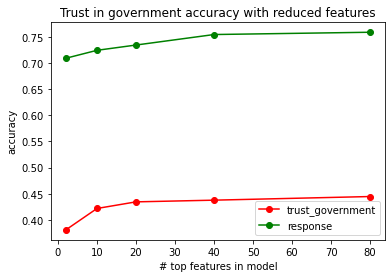

<Figure size 3600x3600 with 0 Axes>

In [43]:
graph = []
graph.append(trustGovGraph)
graph.append(ResponseGraph)

x = np.array(graph)[:,:,0]
y = np.array(graph)[:,:,1]
labels=['trust_government', 'response']
colors=['r','g']

# loop over data, labels and colors
for i in range(len(y)):
    plt.plot(x[i],y[i],'o-',color=colors[i],label=labels[i])

plt.xlabel('# top features in model')
plt.ylabel('accuracy')
plt.title('Trust in government accuracy with reduced features')
plt.legend()
plt.figure(figsize=(50,50))
plt.show()

In [31]:
np.array(graph)

array([[[ 2.        ,  0.38053013],
        [10.        ,  0.42162471],
        [20.        ,  0.43430587],
        [40.        ,  0.43754767],
        [80.        ,  0.44450801]],

       [[ 2.        ,  0.7094775 ],
        [10.        ,  0.72473303],
        [20.        ,  0.73483982],
        [40.        ,  0.75495805],
        [80.        ,  0.75934401]]])